## Use Case

One of our customers strongly believes in technology and have recently backed up its platform using Machine Learning and Artificial Intelligence. Based on data collected from multiple sources on different songs and various artist attributes our customer is excited to challenge the MachineHack community.

By analyzing, the chartbusters data to predict the Views of songs, MachineHackers would advance the state of the current platform. This can help our customer understand user behaviour and personalize the user experience. 
In this hackathon, we challenge the MachineHackers to come up with a prediction algorithm that can predict the views for a given song.

Can you predict how popular a song will be in the future?

## Dataset Description

- Data_Train.csv – the training set, 78458 rows with 11 columns.
- Data_Test.csv – the test set, 19615 rows with 10 columns, except the Views column.
- Sample_Submission.csv – sample submission file format for reference.

## Data Dictionary

- **Unique_ID** : Unique Identifier.
- **Name** : Name of the Artist.
- **Genre** : Genre of the Song.
- **Country** : Origin Country of Artist.
- **Song_Name** : Name of the Song.
- **Timestamp** : Release Date and Time.
- **Views** : Number of times the song was played/viewed (*Target/Dependent Variable*).
- **Comments** : Count of comments for the song.
- **Likes** : Count of Likes.
- **Popularity** : Popularity score for the artist.
- **Followers** : Number of Followers.

## Load necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import holidays
from bisect import bisect_left, bisect_right

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
import emoji

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups

from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam, Nadam, Adamax
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_uniform

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tdtap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tdtap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from learningratefinder import LearningRateFinder
from clr_callback import CyclicLR

In [3]:
print(tf.__version__)

2.0.0


## Set file paths for train and test datasets

In [4]:
train_dataset = "Datasets/Data_Train.csv"
test_dataset = "Datasets/Data_Test.csv"

## Glove Vectors

In [5]:
embeddings_index = {}
f = open('C://Users//tdtap//MLProjects//GLOVE//glove.840B.300d//glove.840B.300d.txt', encoding='utf8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Word vectors found: {}'.format(len(embeddings_index)))

2196017it [08:40, 4220.28it/s]


Word vectors found: 2196016


## Functions to process text data in "Song Name" field

In [6]:
def char_is_emoji(character):
    """
        Description: Function to check if input character is an emoji
    """
    return character in emoji.UNICODE_EMOJI

In [7]:
def text_has_emoji(text):
    """
        Description: Function to check if input text contains an emoji
    """
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            return True
    return False

In [8]:
def deEmojify(inputString):
    """
        Description: Function to remove the emojis in input string
    """
    return inputString.encode('ascii', 'ignore').decode('ascii')

In [9]:
def remove_punctuations(text):
    """
        Description: Function to remove any punctuations in input text
    """

    punct =[]
    punct += list(string.punctuation)
    punct += '’'
    punct += '-'
    punct.remove("'")
    
    for punctuation in punct:
        text = text.replace(punctuation, ' ')
    return text

In [10]:
def nlp(df, field_name):
    """
        Description: Function to perform basic pre-processing in 'Song_Name' field
        
        Parameters:
            df - Input dataframe
            field_name - Field name to be processed
        
        Return:
            df - Processed dataframe
    """
  
    # lowercase everything
    df['token'] = df[field_name].apply(lambda x: x.lower())
    
    # get rid of '\n' from whitespace 
    df['token'] = df['token'].apply(lambda x: x.replace('\n', ' '))
    
    # regex remove hyperlinks
    df['token'] = df['token'].str.replace('http\S+|www.\S+', '', case=False)
    
    # removing '&gt;'
    df['token'] = df['token'].apply(lambda x: x.replace('&gt;', ''))
    
    # Checking if emoji in tokens column
    #df['emoji'] = df['token'].apply(lambda x: text_has_emoji(x))
    
    # Removing Emojis from tokens
    df['token'] = df['token'].apply(lambda x: deEmojify(x))
    
    # remove punctuations
    df['token'] = df['token'].apply(remove_punctuations)
    
    # remove ' s ' that was created after removing punctuations
    df['token'] = df['token'].apply(lambda x: str(x).replace(" s ", " "))
    
    return df

In [11]:
sp = spacy.load('en_core_web_sm')
lookups = Lookups()
lemm = Lemmatizer(lookups)

In [12]:
def lemma_function(text):
    """
        Description: Function to lemmatize the input text
    """

    dummy = []    
    for word in sp(text):
        dummy.append(word.lemma_)
    return ' '.join(dummy)

In [13]:
def sent2vec(text):
    """
        Description: Function to create normalized vector for input text
    """
    
    stop_words = stopwords.words('english')
    words = str(text).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

## Preprocess data + EDA

In [14]:
# Read train/predict data into pandas dataframes
train_df = pd.read_csv(train_dataset)
predict_df = pd.read_csv(test_dataset)

In [16]:
# Remove rows, from train_df, having any column value as NaN
train_df.dropna(inplace=True)

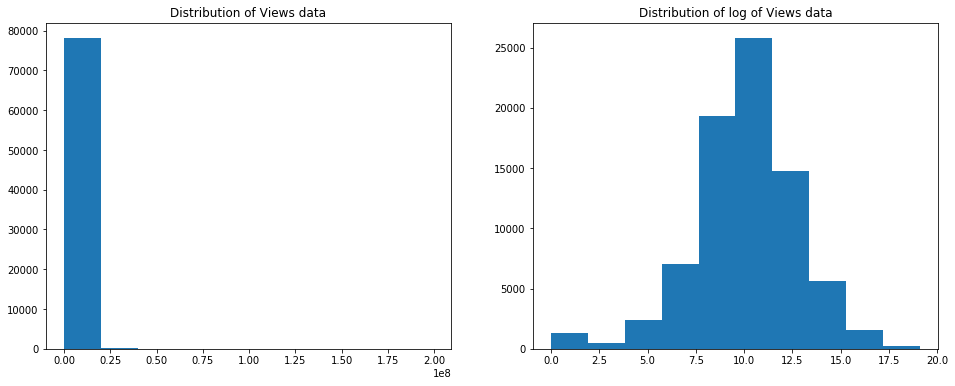

In [17]:
# Plot distribution of data in "Views" field
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train_df['Views']);
plt.title('Distribution of Views data');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train_df['Views']));
plt.title('Distribution of log of Views data');

In [18]:
# Extract "Views" field from train_df into NumPy array
train_df['Views'] = np.log1p(train_df['Views'])
Ytrain = np.array([train_df['Views'].values]).T
train_df.drop(['Views'], inplace=True, axis=1)
print("Ytrain: {}".format(Ytrain.shape))

Ytrain: (78457, 1)


In [19]:
# Combine the train and predict dataframes
combined_df = train_df.append(predict_df, sort=False, ignore_index=True)
print(combined_df.shape)

(98072, 10)


In [20]:
# Drop redundant fields
combined_df.drop(['Unique_ID', 'Country'], inplace=True, axis=1)
print("Number of features: {}".format(combined_df.shape[1]))

Number of features: 8


In [21]:
combined_df.head(10)

,Name,Genre,Song_Name,Timestamp,Comments,Likes,Popularity,Followers
0,Hardstyle,danceedm,N-Vitral presents BOMBSQUAD - Poison Spitter (...,2018-03-30 15:24:45.000000,4,499,97,119563
1,Dj Aladdin,danceedm,Dj Aladdin - Old School Hip Hop Quick Mix,2016-06-20 05:58:52.000000,17,49,17,2141
2,Maxximize On Air,danceedm,Maxximize On Air - Mixed by Blasterjaxx - Epis...,2015-05-08 17:45:59.000000,11,312,91,22248
3,GR6 EXPLODE,rbsoul,MC Yago - Tenho Compromisso (DJ R7),2017-06-08 23:50:03.000000,2,"2,400",76,393655
4,Tritonal,danceedm,Escape (feat. Steph Jones),2016-09-17 20:50:19.000000,81,"3,031",699,201030
5,k$upreme,all-music,Started Off Finessen' (Prod.Oscar100),2017-11-27 14:55:11.000000,6,"4,500",325,71038
6,Hardstyle,danceedm,Coone - Universal Language (Cyber Remix),2016-01-22 17:23:26.000000,15,"1,017",226,119563
7,Diplo,danceedm,Pick Your Poison (feat. Kay) (Figure Remix),2012-01-17 00:00:00.000000,5,88,12,7120051
8,Nick Vanelli,trap,B l o o d s h e d,2018-11-29 22:37:07.000000,0,28,7,1892
9,DeejayEcko(PNCS),latin,CHIHUAHUA MIXDOWN [ Instagram : @deejayeckoo ],2017-09-28 04:07:47.000000,0,622,47,2835


In [22]:
# Extract new features from "Timestamp" field
combined_df['rel_year'] = combined_df['Timestamp'].map(lambda x: pd.to_datetime(x).year)
combined_df['rel_quarter'] = combined_df['Timestamp'].map(lambda x: pd.to_datetime(x).quarter)
combined_df['rel_month'] = combined_df['Timestamp'].map(lambda x: pd.to_datetime(x).month)
combined_df['rel_week'] = combined_df['Timestamp'].map(lambda x: pd.to_datetime(x).week)
combined_df['rel_day_year'] = combined_df['Timestamp'].map(lambda x: pd.to_datetime(x).dayofyear)
combined_df['rel_day_month'] = combined_df['Timestamp'].map(lambda x: pd.to_datetime(x).day)
combined_df['rel_day_week'] = combined_df['Timestamp'].map(lambda x: pd.to_datetime(x).dayofweek)
combined_df['rel_day_weekend'] = np.where(combined_df['rel_day_week'].isin([5,6]),1,0)
combined_df['rel_hour'] = combined_df['Timestamp'].map(lambda x: pd.to_datetime(x).hour)
combined_df['minutes_elapsed'] = combined_df['Timestamp'].map(lambda x: (pd.to_datetime(x) - pd.to_datetime(pd.to_datetime(x).date())).seconds / 60.0)

In [23]:
# Create list of holidays
year_list = list(combined_df['rel_year'].unique())
year_list.append(min(year_list) - 1)
year_list.append(max(year_list) + 1)
year_list.sort()

holiday_list = []
for ptr in holidays.Australia(years = year_list).items():
    holiday_list.append(ptr[0])

holiday_list.sort()
print("Number of holidays: {}".format(len(holiday_list)))

Number of holidays: 273


In [24]:
# Get days difference between "Timestamp" field, and last/next holiday
combined_df['release_date'] = combined_df['Timestamp'].map(lambda x: pd.to_datetime(x).date())
combined_df['last_holiday'] = combined_df['Timestamp'].map(lambda x: holiday_list[bisect_left(holiday_list, pd.to_datetime(x))] 
                                                           if holiday_list[bisect_left(holiday_list, pd.to_datetime(x))] == pd.to_datetime(x) 
                                                           else holiday_list[bisect_left(holiday_list, pd.to_datetime(x)) - 1])
combined_df['next_holiday'] = combined_df['Timestamp'].map(lambda x: holiday_list[bisect_right(holiday_list, pd.to_datetime(x))])
combined_df['days_frm_last_holiday'] = (combined_df['release_date'] - combined_df['last_holiday'])/np.timedelta64(1,'D')
combined_df['days_to_next_holiday'] = (combined_df['next_holiday'] - combined_df['release_date'])/np.timedelta64(1,'D')

In [25]:
# Drop redundant fields
combined_df.drop(['Timestamp', 'release_date', 'last_holiday', 'next_holiday'], inplace=True, axis=1)
print("Number of features: {}".format(combined_df.shape[1]))

Number of features: 19


In [26]:
# Number of words in the "Name" field
combined_df["Name_num_words"] = combined_df["Name"].apply(lambda x: len(str(x).split()))

# Number of unique words in the "Name" field
combined_df["Name_num_unique_words"] = combined_df["Name"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the "Name" field
combined_df["Name_num_chars"] = combined_df["Name"].apply(lambda x: len(str(x)))

# Number of stopwords in the "Name" field
stop = stopwords.words('english')
combined_df["Name_num_stopwords"] = combined_df["Name"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop]))

# Number of punctuations in the "Name" field
combined_df["Name_num_punctuations"] =combined_df['Name'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Number of emojis in the "Name" field
combined_df["Name_num_emojis"] =combined_df['Name'].apply(lambda x: len([c for c in str(x) if c in emoji.UNICODE_EMOJI]))

# Number of title case words in the "Name" field
combined_df["Name_num_words_upper"] = combined_df["Name"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Number of title case words in the "Name" field
combined_df["Name_num_words_title"] = combined_df["Name"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Average length of the words in the "Name" field
combined_df["Name_mean_word_len"] = combined_df["Name"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

print("Number of features: {}".format(combined_df.shape[1]))

Number of features: 28


In [27]:
# Apply basis pre-processing on 'Name' field
combined_df = nlp(combined_df, "Name")

# Lemmatize the 'token' field
combined_df['lemmatized'] = combined_df['token'].apply(lambda x: lemma_function(x))

# Remove any stop-words in 'lemmatized' field
stop = stopwords.words('english')
combined_df['Processed_Name'] = combined_df['lemmatized'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# Remove numbers in 'lemmatized' field
combined_df['Processed_Name'] = combined_df['Processed_Name'].apply(lambda x: " ".join(x for x in x.split() if x.isalpha()))
combined_df.head()

,Name,Genre,Song_Name,Comments,Likes,Popularity,Followers,rel_year,rel_quarter,rel_month,...,Name_num_chars,Name_num_stopwords,Name_num_punctuations,Name_num_emojis,Name_num_words_upper,Name_num_words_title,Name_mean_word_len,token,lemmatized,Processed_Name
0,Hardstyle,danceedm,N-Vitral presents BOMBSQUAD - Poison Spitter (...,4,499,97,119563,2018,1,3,...,9,0,0,0,0,1,9.000000,hardstyle,hardstyle,hardstyle
1,Dj Aladdin,danceedm,Dj Aladdin - Old School Hip Hop Quick Mix,17,49,17,2141,2016,2,6,...,10,0,0,0,0,2,4.500000,dj aladdin,dj aladdin,dj aladdin
2,Maxximize On Air,danceedm,Maxximize On Air - Mixed by Blasterjaxx - Epis...,11,312,91,22248,2015,2,5,...,16,1,0,0,0,3,4.666667,maxximize on air,maxximize on air,maxximize air
3,GR6 EXPLODE,rbsoul,MC Yago - Tenho Compromisso (DJ R7),2,"2,400",76,393655,2017,2,6,...,11,0,0,0,2,0,5.000000,gr6 explode,gr6 explode,explode
4,Tritonal,danceedm,Escape (feat. Steph Jones),81,"3,031",699,201030,2016,3,9,...,8,0,0,0,0,1,8.000000,tritonal,tritonal,tritonal


In [28]:
# Drop redundant fields
combined_df.drop(['Name', 'token', 'lemmatized'], inplace=True, axis=1)
print("Number of features: {}".format(combined_df.shape[1]))

Number of features: 28


In [29]:
# Fit transform the TF-IDF vectorizer on "Name" field
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,4), max_features=200)
name_tfidf = tfidf_vec.fit_transform(combined_df["Processed_Name"].values.tolist())
name_tfidf = pd.DataFrame(name_tfidf.toarray(), columns=tfidf_vec.get_feature_names())
combined_df = pd.concat([combined_df, name_tfidf], axis=1)
print("Number of features: {}".format(combined_df.shape[1]))

Number of features: 228


In [30]:
# Fit transform the Count Vectorizer on "Name" field
count_vec = CountVectorizer(ngram_range=(1,7), analyzer='char', max_features=200)
name_vec = count_vec.fit_transform(combined_df["Processed_Name"].values.tolist())
name_vec = pd.DataFrame(name_vec.toarray(), columns=count_vec.get_feature_names())
combined_df = pd.concat([combined_df, name_vec], axis=1)
print("Number of features: {}".format(combined_df.shape[1]))

Number of features: 428


In [0]:
# One-hot encoding for "Name" field
#dummy_val = pd.get_dummies(combined_df['Processed_Name'], prefix='Name')
#combined_df = pd.concat([combined_df, dummy_val], axis=1)
#print("Number of features: {}".format(combined_df.shape[1]))

Number of features: 1433


In [31]:
# One-hot encoding for "Genre" field
dummy_val = pd.get_dummies(combined_df['Genre'], prefix='Name')
combined_df = pd.concat([combined_df, dummy_val], axis=1)
print("Number of features: {}".format(combined_df.shape[1]))

Number of features: 449


In [32]:
# Number of words in the "Song_Name" field
combined_df["Song_num_words"] = combined_df["Song_Name"].apply(lambda x: len(str(x).split()))

# Number of unique words in the "Song_Name" field
combined_df["Song_num_unique_words"] = combined_df["Song_Name"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the "Song_Name" field
combined_df["Song_num_chars"] = combined_df["Song_Name"].apply(lambda x: len(str(x)))

# Number of stopwords in the "Song_Name" field
stop = stopwords.words('english')
combined_df["Song_num_stopwords"] = combined_df["Song_Name"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop]))

# Number of punctuations in the "Song_Name" field
combined_df["Song_num_punctuations"] =combined_df['Song_Name'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Number of emojis in the "Song_Name" field
combined_df["Song_num_emojis"] =combined_df['Song_Name'].apply(lambda x: len([c for c in str(x) if c in emoji.UNICODE_EMOJI]))

# Number of title case words in the "Song_Name" field
combined_df["Song_num_words_upper"] = combined_df["Song_Name"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Number of title case words in the "Song_Name" field
combined_df["Song_num_words_title"] = combined_df["Song_Name"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Average length of the words in the "Song_Name" field
combined_df["Song_mean_word_len"] = combined_df["Song_Name"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

print("Number of features: {}".format(combined_df.shape[1]))

Number of features: 458


In [33]:
# Apply basis pre-processing on 'Song_Name' field
combined_df = nlp(combined_df, "Song_Name")

# Lemmatize the 'token' field
combined_df['lemmatized'] = combined_df['token'].apply(lambda x: lemma_function(x))

# Remove any stop-words in 'lemmatized' field
stop = stopwords.words('english')
combined_df['Processed_Name'] = combined_df['lemmatized'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# Remove numbers in 'lemmatized' field
combined_df['Processed_Name'] = combined_df['Processed_Name'].apply(lambda x: " ".join(x for x in x.split() if x.isalpha()))
combined_df.head()

,Genre,Song_Name,Comments,Likes,Popularity,Followers,rel_year,rel_quarter,rel_month,rel_week,...,Song_num_unique_words,Song_num_chars,Song_num_stopwords,Song_num_punctuations,Song_num_emojis,Song_num_words_upper,Song_num_words_title,Song_mean_word_len,token,lemmatized
0,danceedm,N-Vitral presents BOMBSQUAD - Poison Spitter (...,4,499,97,119563,2018,1,3,13,...,9,67,0,4,0,1,5,6.555556,n vitral presents bombsquad poison spitter ...,n vitral presents bombsquad poison spitter ...
1,danceedm,Dj Aladdin - Old School Hip Hop Quick Mix,17,49,17,2141,2016,2,6,25,...,9,41,0,1,0,0,8,3.666667,dj aladdin old school hip hop quick mix,dj aladdin old school hip hop quick mix
2,danceedm,Maxximize On Air - Mixed by Blasterjaxx - Epis...,11,312,91,22248,2015,2,5,19,...,9,54,2,3,0,0,6,4.500000,maxximize on air mixed by blasterjaxx epis...,maxximize on air mix by blasterjaxx epis...
3,rbsoul,MC Yago - Tenho Compromisso (DJ R7),2,"2,400",76,393655,2017,2,6,23,...,7,35,0,3,0,3,4,4.142857,mc yago tenho compromisso dj r7,mc yago tenho compromisso dj r7
4,danceedm,Escape (feat. Steph Jones),81,"3,031",699,201030,2016,3,9,37,...,4,26,0,3,0,0,3,5.750000,escape feat steph jones,escape feat steph jones


In [34]:
# Drop redundant fields
combined_df.drop(['Song_Name', 'token', 'lemmatized'], inplace=True, axis=1)
print("Number of features: {}".format(combined_df.shape[1]))

Number of features: 457


In [35]:
# Fit transform the TF-IDF vectorizer on "Song_Name" field
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,4), max_features=300)
name_tfidf = tfidf_vec.fit_transform(combined_df["Processed_Name"].values.tolist())
name_tfidf = pd.DataFrame(name_tfidf.toarray(), columns=tfidf_vec.get_feature_names())
combined_df = pd.concat([combined_df, name_tfidf], axis=1)
print("Number of features: {}".format(combined_df.shape[1]))

Number of features: 757


In [36]:
# Fit transform the Count Vectorizer on "Song_Name" field
count_vec = CountVectorizer(ngram_range=(1,7), analyzer='char', max_features=300)
name_vec = count_vec.fit_transform(combined_df["Processed_Name"].values.tolist())
name_vec = pd.DataFrame(name_vec.toarray(), columns=count_vec.get_feature_names())
combined_df = pd.concat([combined_df, name_vec], axis=1)
print("Number of features: {}".format(combined_df.shape[1]))

Number of features: 1057


In [37]:
# Create Glove vectors using "Processed_Name" field
glove_vec = [sent2vec(x) for x in tqdm(combined_df["Processed_Name"].values)]
glove_vec_df = pd.DataFrame(np.array(glove_vec))
glove_vec_df.columns = ['glove_syn_'+str(i) for i in range(300)]
print(glove_vec_df.shape)

100%|███████████████████████████████████████████████████████████████████████████| 98072/98072 [09:40<00:00, 168.96it/s]


(98072, 300)


In [38]:
combined_df = pd.concat([combined_df, glove_vec_df], axis=1)
print("Number of features: {}".format(combined_df.shape[1]))

Number of features: 1357


In [39]:
# Cleanse data in "Likes" field
combined_df['Likes'] = combined_df['Likes'].map(lambda x: x.replace(",", ""))
combined_df['Likes'] = (combined_df.Likes.replace(r'[KM]+$', '', regex=True).astype(float) * 
                        combined_df.Likes.str.extract(r'[\d\.]+([KM]+)', expand=False)
                        .fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))
print("Number of features: {}".format(combined_df.shape[1]))

Number of features: 1357


In [40]:
# Cleanse data in "Popularity" field
combined_df['Popularity'] = combined_df['Popularity'].map(lambda x: x.replace(",", ""))
combined_df['Popularity'] = (combined_df.Popularity.replace(r'[KM]+$', '', regex=True).astype(float) * 
                             combined_df.Popularity.str.extract(r'[\d\.]+([KM]+)', expand=False)
                             .fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))
print("Number of features: {}".format(combined_df.shape[1]))

Number of features: 1357


In [41]:
# Drop redundant columns
combined_df.drop(['Processed_Name'], inplace=True, axis=1)

In [42]:
# Drop redundant columns
combined_df.drop(['Genre'], inplace=True, axis=1)

In [43]:
# Check if any column has NaN value in dataframe
print("Column with NaN value: {}".format(combined_df.columns[combined_df.isnull().any()].tolist()))

Column with NaN value: []


In [44]:
# Segregate combined_df into train/predict datasets
Xtrain = combined_df[:78457].values
Xpredict = combined_df[78457:].values
print("Xtrain: {}".format(Xtrain.shape))
print("Xpredict: {}".format(Xpredict.shape))

Xtrain: (78457, 1355)
Xpredict: (19615, 1355)


In [45]:
# Scale the Xtrain/Xpredict datasets
scaler_x = RobustScaler().fit(Xtrain)
Xtrain = scaler_x.transform(Xtrain)
Xpredict = scaler_x.transform(Xpredict)

## Save the datasets in NPZ file (for reusability)

In [46]:
np.savez_compressed('Datasets/Chartbusters_Songs_Popularity_Prediction_dataset.npz',
                    Xtrain=Xtrain, 
                    Ytrain=Ytrain,
                    Xpredict=Xpredict)

## Load datasets from the NPZ file

In [15]:
# Read the training, holdout and test datasets from processed file
processed_dataset = np.load('Datasets/Chartbusters_Songs_Popularity_Prediction_dataset.npz', allow_pickle=True)
Xtrain, Ytrain, Xpredict = processed_dataset['Xtrain'], processed_dataset['Ytrain'], processed_dataset['Xpredict']
print("Xtrain: {} \nYtrain: {} \nXpredict: {}".format(Xtrain.shape, Ytrain.shape, Xpredict.shape))

Xtrain: (78457, 1355) 
Ytrain: (78457, 1) 
Xpredict: (19615, 1355)


## Create train and test datasets

In [16]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xtrain, Ytrain, test_size=0.05, random_state=10)
print("Xtrain: {} \nYtrain: {}".format(Xtrain.shape, Ytrain.shape))
print("Xtest: {} \nYtest: {}".format(Xtest.shape, Ytest.shape))

Xtrain: (74534, 1355) 
Ytrain: (74534, 1)
Xtest: (3923, 1355) 
Ytest: (3923, 1)


## Define custom loss function for calculating RMSE

In [17]:
def custom_loss_rmse(y_true, y_pred):
    """
        Description: Function to calculate root-mean-squared-error (RMSE) value
        
        Parameters:
            y_true: True outputs
            y_pred: Predicted outputs
        
        Return: Calculated RMSE value
    """

    return tf.sqrt(tf.reduce_mean((y_true - y_pred)**2))

## Build the model

In [18]:
def nn_model(num_of_features):
    """
        Description: Function to build the neural network model
        
        Parameters:
            num_of_features: Number of features in input data
        
        Return:
            model - Keras neural network Model
    """

    # Input Layer
    x_input = Input(shape=(num_of_features, ), name='INPUT')

    # Fully-connected Layer 1
    x = Dense(units=1024, name='FC-1', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x_input)
    x = BatchNormalization(name='BN_FC-1')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-1')(x)

    # Fully-connected Layer 2
    x = Dense(units=1024, name='FC-2', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-2')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-2')(x)

    # Fully-connected Layer 3
    x = Dense(units=1024, name='FC-3', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-3')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-3')(x)

    # Fully-connected Layer 4
    x = Dense(units=512, name='FC-4', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-4')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-4')(x)

    # Fully-connected Layer 5
    x = Dense(units=512, name='FC-5', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-5')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-5')(x)

    # Fully-connected Layer 6
    x = Dense(units=512, name='FC-6', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-6')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-6')(x)

    # Fully-connected Layer 7
    x = Dense(units=256, name='FC-7', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-7')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-7')(x)

    # Fully-connected Layer 8
    x = Dense(units=256, name='FC-8', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-8')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-8')(x)

    # Fully-connected Layer 9
    x = Dense(units=256, name='FC-9', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-9')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-9')(x)

    # Fully-connected Layer 10
    x = Dense(units=128, name='FC-10', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-10')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-10')(x)

    # Fully-connected Layer 11
    x = Dense(units=128, name='FC-11', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-11')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-11')(x)

    # Fully-connected Layer 12
    x = Dense(units=128, name='FC-12', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-12')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-12')(x)

    # Fully-connected Layer 13
    x = Dense(units=64, name='FC-13', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-13')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-13')(x)

    # Fully-connected Layer 14
    x = Dense(units=64, name='FC-14', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-14')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-14')(x)

    # Fully-connected Layer 15
    x = Dense(units=64, name='FC-15', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-15')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-15')(x)

    # Fully-connected Layer 16
    x = Dense(units=32, name='FC-16', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-16')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-16')(x)

    # Fully-connected Layer 17
    x = Dense(units=32, name='FC-17', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-17')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-17')(x)

    # Fully-connected Layer 18
    x = Dense(units=32, name='FC-18', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-18')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-18')(x)

    # Output Layer
    x = Dense(units=1, name='OUTPUT', activation='linear', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)

    # Create Keras Model instance
    model = Model(inputs=x_input, outputs=x, name='Chartbusters_Songs_Popularity_Predictor')
    
    return model

In [19]:
# Define the model hyperparameters
max_iterations = 50
mini_batch_size = 256
min_lr = 1e-5
max_lr = 1e-2
step_size = 8 * (Xtrain.shape[0] // mini_batch_size)
clr_method = 'triangular2'

In [57]:
# Create the model
model = nn_model(Xtrain.shape[1])

# Compile model to configure the learning process
model.compile(loss=custom_loss_rmse,
              optimizer=Adam(lr=min_lr),
              metrics=[RootMeanSquaredError()])

# Triangular learning rate policy
clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, mode=clr_method, step_size=step_size)

Train on 74534 samples
Epoch 1/8
32512/74534 [============>.................] - ETA: 1:30:22 - loss: 1219.8500 - root_mean_squared_error: 10.46 - ETA: 45:44 - loss: 1219.9166 - root_mean_squared_error: 10.5310 - ETA: 30:46 - loss: 1219.9983 - root_mean_squared_error: 10.61 - ETA: 23:17 - loss: 1219.9838 - root_mean_squared_error: 10.59 - ETA: 18:49 - loss: 1219.9650 - root_mean_squared_error: 10.57 - ETA: 15:49 - loss: 1219.9473 - root_mean_squared_error: 10.56 - ETA: 13:42 - loss: 1219.9259 - root_mean_squared_error: 10.54 - ETA: 12:05 - loss: 1219.9110 - root_mean_squared_error: 10.52 - ETA: 10:51 - loss: 1219.9197 - root_mean_squared_error: 10.53 - ETA: 9:51 - loss: 1219.9481 - root_mean_squared_error: 10.5631 - ETA: 9:01 - loss: 1219.9553 - root_mean_squared_error: 10.570 - ETA: 8:20 - loss: 1219.9353 - root_mean_squared_error: 10.550 - ETA: 7:45 - loss: 1219.9497 - root_mean_squared_error: 10.564 - ETA: 7:15 - loss: 1219.9377 - root_mean_squared_error: 10.552 - ETA: 6:49 - loss: 1

33536/74534 [============>.................] - ETA: 1:02 - loss: 1219.7397 - root_mean_squared_error: 10.353 - ETA: 1:03 - loss: 1219.8695 - root_mean_squared_error: 10.484 - ETA: 1:03 - loss: 1219.7502 - root_mean_squared_error: 10.366 - ETA: 1:02 - loss: 1219.7546 - root_mean_squared_error: 10.370 - ETA: 1:02 - loss: 1219.8125 - root_mean_squared_error: 10.428 - ETA: 1:02 - loss: 1219.8846 - root_mean_squared_error: 10.501 - ETA: 1:02 - loss: 1219.9384 - root_mean_squared_error: 10.555 - ETA: 1:02 - loss: 1219.9238 - root_mean_squared_error: 10.540 - ETA: 1:02 - loss: 1219.9211 - root_mean_squared_error: 10.537 - ETA: 1:02 - loss: 1219.9307 - root_mean_squared_error: 10.547 - ETA: 1:02 - loss: 1219.9157 - root_mean_squared_error: 10.532 - ETA: 1:01 - loss: 1219.9076 - root_mean_squared_error: 10.523 - ETA: 1:01 - loss: 1219.9166 - root_mean_squared_error: 10.532 - ETA: 1:01 - loss: 1219.9171 - root_mean_squared_error: 10.533 - ETA: 1:01 - loss: 1219.9217 - root_mean_squared_error: 10

74534/74534 [==============================] - ETA: 6s - loss: 1219.9581 - root_mean_squared_error: 10.577 - ETA: 6s - loss: 1219.9576 - root_mean_squared_error: 10.576 - ETA: 6s - loss: 1219.9583 - root_mean_squared_error: 10.577 - ETA: 5s - loss: 1219.9573 - root_mean_squared_error: 10.576 - ETA: 5s - loss: 1219.9570 - root_mean_squared_error: 10.576 - ETA: 5s - loss: 1219.9582 - root_mean_squared_error: 10.577 - ETA: 5s - loss: 1219.9582 - root_mean_squared_error: 10.577 - ETA: 4s - loss: 1219.9581 - root_mean_squared_error: 10.577 - ETA: 4s - loss: 1219.9577 - root_mean_squared_error: 10.577 - ETA: 4s - loss: 1219.9575 - root_mean_squared_error: 10.576 - ETA: 4s - loss: 1219.9570 - root_mean_squared_error: 10.576 - ETA: 4s - loss: 1219.9572 - root_mean_squared_error: 10.576 - ETA: 3s - loss: 1219.9577 - root_mean_squared_error: 10.577 - ETA: 3s - loss: 1219.9576 - root_mean_squared_error: 10.577 - ETA: 3s - loss: 1219.9578 - root_mean_squared_error: 10.577 - ETA: 3s - loss: 1219.95

33280/74534 [============>.................] - ETA: 1:10 - loss: 1219.5244 - root_mean_squared_error: 10.515 - ETA: 1:09 - loss: 1219.4608 - root_mean_squared_error: 10.454 - ETA: 1:09 - loss: 1219.5794 - root_mean_squared_error: 10.575 - ETA: 1:09 - loss: 1219.6682 - root_mean_squared_error: 10.667 - ETA: 1:08 - loss: 1219.7357 - root_mean_squared_error: 10.736 - ETA: 1:08 - loss: 1219.7258 - root_mean_squared_error: 10.728 - ETA: 1:09 - loss: 1219.7518 - root_mean_squared_error: 10.755 - ETA: 1:09 - loss: 1219.7258 - root_mean_squared_error: 10.731 - ETA: 1:09 - loss: 1219.7199 - root_mean_squared_error: 10.727 - ETA: 1:09 - loss: 1219.7076 - root_mean_squared_error: 10.716 - ETA: 1:09 - loss: 1219.6929 - root_mean_squared_error: 10.703 - ETA: 1:09 - loss: 1219.6820 - root_mean_squared_error: 10.694 - ETA: 1:09 - loss: 1219.6872 - root_mean_squared_error: 10.701 - ETA: 1:09 - loss: 1219.6629 - root_mean_squared_error: 10.679 - ETA: 1:09 - loss: 1219.6396 - root_mean_squared_error: 10

74534/74534 [==============================] - ETA: 7s - loss: 1218.4510 - root_mean_squared_error: 10.584 - ETA: 6s - loss: 1218.4413 - root_mean_squared_error: 10.584 - ETA: 6s - loss: 1218.4315 - root_mean_squared_error: 10.583 - ETA: 6s - loss: 1218.4223 - root_mean_squared_error: 10.583 - ETA: 6s - loss: 1218.4121 - root_mean_squared_error: 10.582 - ETA: 5s - loss: 1218.4029 - root_mean_squared_error: 10.583 - ETA: 5s - loss: 1218.3933 - root_mean_squared_error: 10.583 - ETA: 5s - loss: 1218.3846 - root_mean_squared_error: 10.583 - ETA: 5s - loss: 1218.3735 - root_mean_squared_error: 10.582 - ETA: 4s - loss: 1218.3638 - root_mean_squared_error: 10.582 - ETA: 4s - loss: 1218.3532 - root_mean_squared_error: 10.581 - ETA: 4s - loss: 1218.3427 - root_mean_squared_error: 10.581 - ETA: 4s - loss: 1218.3326 - root_mean_squared_error: 10.580 - ETA: 3s - loss: 1218.3224 - root_mean_squared_error: 10.580 - ETA: 3s - loss: 1218.3124 - root_mean_squared_error: 10.580 - ETA: 3s - loss: 1218.30

33280/74534 [============>.................] - ETA: 1:12 - loss: 1154.6846 - root_mean_squared_error: 10.885 - ETA: 1:15 - loss: 1154.2583 - root_mean_squared_error: 10.740 - ETA: 1:18 - loss: 1153.8867 - root_mean_squared_error: 10.650 - ETA: 1:16 - loss: 1153.5779 - root_mean_squared_error: 10.624 - ETA: 1:16 - loss: 1153.3007 - root_mean_squared_error: 10.631 - ETA: 1:15 - loss: 1152.9618 - root_mean_squared_error: 10.578 - ETA: 1:15 - loss: 1152.6804 - root_mean_squared_error: 10.584 - ETA: 1:15 - loss: 1152.3938 - root_mean_squared_error: 10.586 - ETA: 1:14 - loss: 1152.0661 - root_mean_squared_error: 10.550 - ETA: 1:13 - loss: 1151.7610 - root_mean_squared_error: 10.537 - ETA: 1:13 - loss: 1151.4637 - root_mean_squared_error: 10.533 - ETA: 1:13 - loss: 1151.1876 - root_mean_squared_error: 10.553 - ETA: 1:12 - loss: 1150.8681 - root_mean_squared_error: 10.530 - ETA: 1:12 - loss: 1150.5751 - root_mean_squared_error: 10.536 - ETA: 1:12 - loss: 1150.2755 - root_mean_squared_error: 10

74534/74534 [==============================] - ETA: 7s - loss: 996.2829 - root_mean_squared_error: 10.46 - ETA: 7s - loss: 995.2311 - root_mean_squared_error: 10.46 - ETA: 6s - loss: 994.1758 - root_mean_squared_error: 10.46 - ETA: 6s - loss: 993.1153 - root_mean_squared_error: 10.46 - ETA: 6s - loss: 992.0525 - root_mean_squared_error: 10.46 - ETA: 6s - loss: 990.9850 - root_mean_squared_error: 10.46 - ETA: 5s - loss: 989.9135 - root_mean_squared_error: 10.46 - ETA: 5s - loss: 988.8375 - root_mean_squared_error: 10.46 - ETA: 5s - loss: 987.7576 - root_mean_squared_error: 10.46 - ETA: 4s - loss: 986.6733 - root_mean_squared_error: 10.46 - ETA: 4s - loss: 985.5848 - root_mean_squared_error: 10.46 - ETA: 4s - loss: 984.4920 - root_mean_squared_error: 10.45 - ETA: 4s - loss: 983.3967 - root_mean_squared_error: 10.45 - ETA: 3s - loss: 982.2971 - root_mean_squared_error: 10.45 - ETA: 3s - loss: 981.1920 - root_mean_squared_error: 10.45 - ETA: 3s - loss: 980.0844 - root_mean_squared_error: 1

34816/74534 [=============>................] - ETA: 1:17 - loss: 15.8417 - root_mean_squared_error: 3.43 - ETA: 1:15 - loss: 16.3881 - root_mean_squared_error: 3.36 - ETA: 1:15 - loss: 17.2074 - root_mean_squared_error: 3.36 - ETA: 1:15 - loss: 18.1428 - root_mean_squared_error: 3.34 - ETA: 1:14 - loss: 19.2008 - root_mean_squared_error: 3.33 - ETA: 1:13 - loss: 20.2876 - root_mean_squared_error: 3.30 - ETA: 1:13 - loss: 21.4724 - root_mean_squared_error: 3.34 - ETA: 1:12 - loss: 22.6369 - root_mean_squared_error: 3.36 - ETA: 1:11 - loss: 23.7460 - root_mean_squared_error: 3.35 - ETA: 1:11 - loss: 24.8217 - root_mean_squared_error: 3.34 - ETA: 1:11 - loss: 25.8378 - root_mean_squared_error: 3.33 - ETA: 1:10 - loss: 26.8224 - root_mean_squared_error: 3.35 - ETA: 1:10 - loss: 27.7158 - root_mean_squared_error: 3.34 - ETA: 1:10 - loss: 28.5517 - root_mean_squared_error: 3.35 - ETA: 1:10 - loss: 29.2960 - root_mean_squared_error: 3.35 - ETA: 1:09 - loss: 29.9666 - root_mean_squared_error: 

74534/74534 [==============================] - ETA: 4s - loss: 22.8055 - root_mean_squared_error: 3.15 - ETA: 4s - loss: 22.8014 - root_mean_squared_error: 3.15 - ETA: 3s - loss: 22.8012 - root_mean_squared_error: 3.15 - ETA: 3s - loss: 22.8045 - root_mean_squared_error: 3.15 - ETA: 3s - loss: 22.8097 - root_mean_squared_error: 3.15 - ETA: 3s - loss: 22.8166 - root_mean_squared_error: 3.15 - ETA: 2s - loss: 22.8254 - root_mean_squared_error: 3.15 - ETA: 2s - loss: 22.8351 - root_mean_squared_error: 3.15 - ETA: 2s - loss: 22.8443 - root_mean_squared_error: 3.15 - ETA: 2s - loss: 22.8501 - root_mean_squared_error: 3.15 - ETA: 1s - loss: 22.8529 - root_mean_squared_error: 3.15 - ETA: 1s - loss: 22.8533 - root_mean_squared_error: 3.15 - ETA: 1s - loss: 22.8533 - root_mean_squared_error: 3.15 - ETA: 1s - loss: 22.8552 - root_mean_squared_error: 3.15 - ETA: 0s - loss: 22.8624 - root_mean_squared_error: 3.15 - ETA: 0s - loss: 22.8812 - root_mean_squared_error: 3.15 - ETA: 0s - loss: 22.9161 -

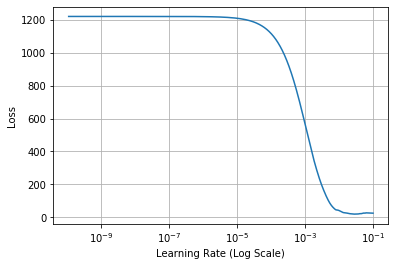

In [55]:
# Learning Rate Finder
lrf = LearningRateFinder(model)
lrf.find((Xtrain, Ytrain),
         startLR=1e-10, endLR=1e-1,
         stepsPerEpoch=np.ceil((len(Xtrain) / float(mini_batch_size))),
         batchSize=mini_batch_size)
lrf.plot_loss()
plt.grid()
plt.show()

In [20]:
# Define 5-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=10)
cvscores = []
y_pred = 0
Ypredict = 0
loss_values = {}
rmse_values = {}

In [21]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain, Ytrain):
    counter += 1
    train_x, train_y = Xtrain[train], Ytrain[train]
    val_x, val_y = Xtrain[val], Ytrain[val]

    # Create the model
    model = nn_model(Xtrain.shape[1])

    # Compile model to configure the learning process
    model.compile(loss=custom_loss_rmse, optimizer=Adam(lr=min_lr), metrics=[RootMeanSquaredError()])

    # Triangular learning rate policy
    clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, mode=clr_method, step_size=step_size)

    # Fit the model
    history = model.fit(x=train_x, y=train_y, 
                        batch_size=mini_batch_size, epochs=150, 
                        callbacks=[clr], workers=5,
                        validation_data=(val_x, val_y))
    
    # Store the score values on validation dataset
    scores = model.evaluate(x=Xtest, y=Ytest, verbose=0)
    print("%s: %.2f" % (model.metrics_names[1], scores[1]))
    cvscores.append(scores[1])

    # Run predictions
    pred1 = model.predict(x=Xtest)
    pred2 = model.predict(x=Xpredict)
    y_pred += pred1
    Ypredict += pred2

    # Store the history object values for learning curves plotting
    loss_values["train_loss_"+str(counter)] = history.history['loss']
    rmse_values["train_rmse_"+str(counter)] = history.history['root_mean_squared_error']

print("%.2f (+/- %.2f)" % (np.mean(cvscores), np.std(cvscores)))
y_pred /= float(counter)
Ypredict /= float(counter)

Train on 59627 samples, validate on 14907 samples
Epoch 1/150
32512/59627 [===============>..............] - ETA: 1:12:09 - loss: 1220.0397 - root_mean_squared_error: 10.65 - ETA: 36:32 - loss: 1219.7642 - root_mean_squared_error: 10.4522 - ETA: 24:38 - loss: 1219.7010 - root_mean_squared_error: 10.48 - ETA: 18:41 - loss: 1219.5926 - root_mean_squared_error: 10.49 - ETA: 15:06 - loss: 1219.4631 - root_mean_squared_error: 10.50 - ETA: 12:42 - loss: 1219.2722 - root_mean_squared_error: 10.47 - ETA: 11:00 - loss: 1219.1230 - root_mean_squared_error: 10.51 - ETA: 9:43 - loss: 1218.9733 - root_mean_squared_error: 10.5645 - ETA: 8:44 - loss: 1218.7504 - root_mean_squared_error: 10.563 - ETA: 7:56 - loss: 1218.5226 - root_mean_squared_error: 10.578 - ETA: 7:17 - loss: 1218.2689 - root_mean_squared_error: 10.587 - ETA: 6:44 - loss: 1217.9739 - root_mean_squared_error: 10.575 - ETA: 6:17 - loss: 1217.6832 - root_mean_squared_error: 10.587 - ETA: 5:53 - loss: 1217.3615 - root_mean_squared_error:

34816/59627 [================>.............] - ETA: 1:08 - loss: 361.7304 - root_mean_squared_error: 9.426 - ETA: 1:06 - loss: 360.2641 - root_mean_squared_error: 9.586 - ETA: 1:05 - loss: 358.7258 - root_mean_squared_error: 9.664 - ETA: 1:05 - loss: 357.1220 - root_mean_squared_error: 9.667 - ETA: 1:04 - loss: 355.4930 - root_mean_squared_error: 9.636 - ETA: 1:04 - loss: 353.9303 - root_mean_squared_error: 9.663 - ETA: 1:04 - loss: 352.3195 - root_mean_squared_error: 9.634 - ETA: 1:03 - loss: 350.7565 - root_mean_squared_error: 9.645 - ETA: 1:03 - loss: 349.2093 - root_mean_squared_error: 9.665 - ETA: 1:03 - loss: 347.6542 - root_mean_squared_error: 9.669 - ETA: 1:03 - loss: 346.0960 - root_mean_squared_error: 9.663 - ETA: 1:02 - loss: 344.5702 - root_mean_squared_error: 9.682 - ETA: 1:02 - loss: 343.0308 - root_mean_squared_error: 9.680 - ETA: 1:02 - loss: 341.4933 - root_mean_squared_error: 9.673 - ETA: 1:01 - loss: 339.9609 - root_mean_squared_error: 9.663 - ETA: 1:01 - loss: 338.4

59627/59627 [==============================] - ETA: 27s - loss: 204.2768 - root_mean_squared_error: 8.51 - ETA: 26s - loss: 203.4970 - root_mean_squared_error: 8.49 - ETA: 26s - loss: 202.7210 - root_mean_squared_error: 8.48 - ETA: 26s - loss: 201.9482 - root_mean_squared_error: 8.46 - ETA: 26s - loss: 201.1812 - root_mean_squared_error: 8.45 - ETA: 25s - loss: 200.4180 - root_mean_squared_error: 8.43 - ETA: 25s - loss: 199.6604 - root_mean_squared_error: 8.42 - ETA: 25s - loss: 198.9069 - root_mean_squared_error: 8.40 - ETA: 24s - loss: 198.1534 - root_mean_squared_error: 8.39 - ETA: 24s - loss: 197.4072 - root_mean_squared_error: 8.37 - ETA: 24s - loss: 196.6632 - root_mean_squared_error: 8.35 - ETA: 24s - loss: 195.9257 - root_mean_squared_error: 8.34 - ETA: 23s - loss: 195.1924 - root_mean_squared_error: 8.32 - ETA: 23s - loss: 194.4609 - root_mean_squared_error: 8.31 - ETA: 23s - loss: 193.7353 - root_mean_squared_error: 8.29 - ETA: 22s - loss: 193.0149 - root_mean_squared_error: 

35840/59627 [=================>............] - ETA: 1:07 - loss: 8.6636 - root_mean_squared_error: 3.151 - ETA: 1:06 - loss: 8.4091 - root_mean_squared_error: 2.923 - ETA: 1:04 - loss: 8.4277 - root_mean_squared_error: 2.957 - ETA: 1:04 - loss: 8.3483 - root_mean_squared_error: 2.897 - ETA: 1:04 - loss: 8.3601 - root_mean_squared_error: 2.929 - ETA: 1:03 - loss: 8.3959 - root_mean_squared_error: 2.986 - ETA: 1:03 - loss: 8.3371 - root_mean_squared_error: 2.949 - ETA: 1:03 - loss: 8.2889 - root_mean_squared_error: 2.922 - ETA: 1:02 - loss: 8.2454 - root_mean_squared_error: 2.900 - ETA: 1:02 - loss: 8.2405 - root_mean_squared_error: 2.916 - ETA: 1:01 - loss: 8.2076 - root_mean_squared_error: 2.905 - ETA: 1:00 - loss: 8.1900 - root_mean_squared_error: 2.910 - ETA: 1:00 - loss: 8.1858 - root_mean_squared_error: 2.930 - ETA: 1:00 - loss: 8.1478 - root_mean_squared_error: 2.916 - ETA: 1:00 - loss: 8.1394 - root_mean_squared_error: 2.932 - ETA: 59s - loss: 8.1240 - root_mean_squared_error: 2.

59627/59627 [==============================] - ETA: 25s - loss: 7.7177 - root_mean_squared_error: 2.89 - ETA: 24s - loss: 7.7180 - root_mean_squared_error: 2.89 - ETA: 24s - loss: 7.7161 - root_mean_squared_error: 2.89 - ETA: 24s - loss: 7.7161 - root_mean_squared_error: 2.89 - ETA: 24s - loss: 7.7146 - root_mean_squared_error: 2.89 - ETA: 23s - loss: 7.7116 - root_mean_squared_error: 2.88 - ETA: 23s - loss: 7.7091 - root_mean_squared_error: 2.88 - ETA: 23s - loss: 7.7091 - root_mean_squared_error: 2.88 - ETA: 22s - loss: 7.7091 - root_mean_squared_error: 2.88 - ETA: 22s - loss: 7.7101 - root_mean_squared_error: 2.88 - ETA: 22s - loss: 7.7077 - root_mean_squared_error: 2.88 - ETA: 22s - loss: 7.7077 - root_mean_squared_error: 2.88 - ETA: 21s - loss: 7.7058 - root_mean_squared_error: 2.88 - ETA: 21s - loss: 7.7035 - root_mean_squared_error: 2.88 - ETA: 21s - loss: 7.7025 - root_mean_squared_error: 2.88 - ETA: 21s - loss: 7.7007 - root_mean_squared_error: 2.88 - ETA: 20s - loss: 7.6989 -

35840/59627 [=================>............] - ETA: 1:08 - loss: 6.4214 - root_mean_squared_error: 2.634 - ETA: 1:06 - loss: 6.4994 - root_mean_squared_error: 2.701 - ETA: 1:06 - loss: 6.4933 - root_mean_squared_error: 2.679 - ETA: 1:07 - loss: 6.4697 - root_mean_squared_error: 2.639 - ETA: 1:06 - loss: 6.5323 - root_mean_squared_error: 2.685 - ETA: 1:05 - loss: 6.5007 - root_mean_squared_error: 2.638 - ETA: 1:05 - loss: 6.5539 - root_mean_squared_error: 2.676 - ETA: 1:04 - loss: 6.5476 - root_mean_squared_error: 2.656 - ETA: 1:03 - loss: 6.5443 - root_mean_squared_error: 2.641 - ETA: 1:02 - loss: 6.5608 - root_mean_squared_error: 2.647 - ETA: 1:01 - loss: 6.5646 - root_mean_squared_error: 2.642 - ETA: 1:01 - loss: 6.5751 - root_mean_squared_error: 2.643 - ETA: 1:01 - loss: 6.5932 - root_mean_squared_error: 2.653 - ETA: 1:00 - loss: 6.6034 - root_mean_squared_error: 2.655 - ETA: 1:00 - loss: 6.6087 - root_mean_squared_error: 2.652 - ETA: 1:00 - loss: 6.6211 - root_mean_squared_error: 2

59627/59627 [==============================] - ETA: 25s - loss: 6.5183 - root_mean_squared_error: 2.66 - ETA: 25s - loss: 6.5229 - root_mean_squared_error: 2.66 - ETA: 24s - loss: 6.5277 - root_mean_squared_error: 2.66 - ETA: 24s - loss: 6.5311 - root_mean_squared_error: 2.66 - ETA: 24s - loss: 6.5351 - root_mean_squared_error: 2.66 - ETA: 24s - loss: 6.5378 - root_mean_squared_error: 2.66 - ETA: 23s - loss: 6.5398 - root_mean_squared_error: 2.66 - ETA: 23s - loss: 6.5414 - root_mean_squared_error: 2.66 - ETA: 23s - loss: 6.5420 - root_mean_squared_error: 2.65 - ETA: 22s - loss: 6.5411 - root_mean_squared_error: 2.65 - ETA: 22s - loss: 6.5409 - root_mean_squared_error: 2.65 - ETA: 22s - loss: 6.5399 - root_mean_squared_error: 2.65 - ETA: 22s - loss: 6.5374 - root_mean_squared_error: 2.65 - ETA: 21s - loss: 6.5371 - root_mean_squared_error: 2.65 - ETA: 21s - loss: 6.5368 - root_mean_squared_error: 2.65 - ETA: 21s - loss: 6.5355 - root_mean_squared_error: 2.65 - ETA: 21s - loss: 6.5327 -

35840/59627 [=================>............] - ETA: 1:08 - loss: 8.0606 - root_mean_squared_error: 2.726 - ETA: 1:06 - loss: 8.3736 - root_mean_squared_error: 2.838 - ETA: 1:06 - loss: 8.6413 - root_mean_squared_error: 2.860 - ETA: 1:04 - loss: 8.8052 - root_mean_squared_error: 2.761 - ETA: 1:04 - loss: 9.1025 - root_mean_squared_error: 2.783 - ETA: 1:03 - loss: 9.3677 - root_mean_squared_error: 2.776 - ETA: 1:03 - loss: 9.6877 - root_mean_squared_error: 2.836 - ETA: 1:02 - loss: 9.9355 - root_mean_squared_error: 2.834 - ETA: 1:02 - loss: 10.1452 - root_mean_squared_error: 2.81 - ETA: 1:02 - loss: 10.3433 - root_mean_squared_error: 2.80 - ETA: 1:01 - loss: 10.5214 - root_mean_squared_error: 2.80 - ETA: 1:00 - loss: 10.6440 - root_mean_squared_error: 2.78 - ETA: 1:00 - loss: 10.7418 - root_mean_squared_error: 2.76 - ETA: 1:00 - loss: 10.8108 - root_mean_squared_error: 2.75 - ETA: 59s - loss: 10.8363 - root_mean_squared_error: 2.7318 - ETA: 59s - loss: 10.8696 - root_mean_squared_error: 

59627/59627 [==============================] - ETA: 25s - loss: 8.8100 - root_mean_squared_error: 2.59 - ETA: 24s - loss: 8.8165 - root_mean_squared_error: 2.59 - ETA: 24s - loss: 8.8265 - root_mean_squared_error: 2.59 - ETA: 24s - loss: 8.8367 - root_mean_squared_error: 2.59 - ETA: 24s - loss: 8.8472 - root_mean_squared_error: 2.59 - ETA: 23s - loss: 8.8547 - root_mean_squared_error: 2.59 - ETA: 23s - loss: 8.8623 - root_mean_squared_error: 2.59 - ETA: 23s - loss: 8.8678 - root_mean_squared_error: 2.59 - ETA: 23s - loss: 8.8728 - root_mean_squared_error: 2.59 - ETA: 22s - loss: 8.8757 - root_mean_squared_error: 2.59 - ETA: 22s - loss: 8.8770 - root_mean_squared_error: 2.59 - ETA: 22s - loss: 8.8743 - root_mean_squared_error: 2.59 - ETA: 21s - loss: 8.8718 - root_mean_squared_error: 2.59 - ETA: 21s - loss: 8.8643 - root_mean_squared_error: 2.59 - ETA: 21s - loss: 8.8581 - root_mean_squared_error: 2.59 - ETA: 21s - loss: 8.8506 - root_mean_squared_error: 2.59 - ETA: 20s - loss: 8.8441 -

KeyboardInterrupt: 

In [0]:
test_rmse = np.sqrt(np.mean((y_pred - Ytest)**2))
print(test_rmse)

0.7317305975483955


## Plot the learning curves to show the learning process

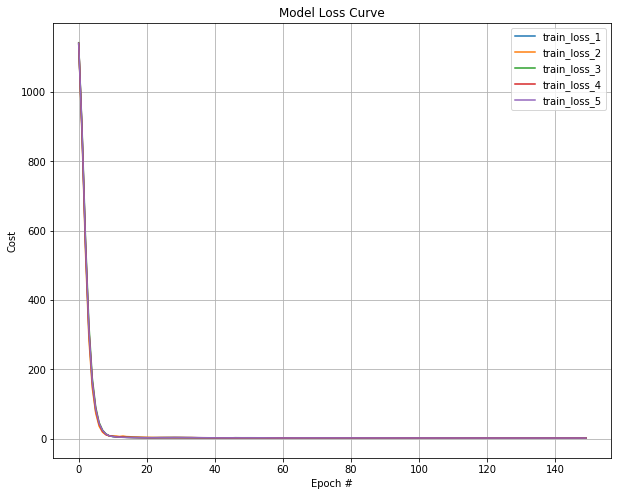

In [0]:
plt.figure(figsize=(10,8))
plt.plot(loss_values["train_loss_1"], label='train_loss_1')
plt.plot(loss_values["train_loss_2"], label='train_loss_2')
plt.plot(loss_values["train_loss_3"], label='train_loss_3')
plt.plot(loss_values["train_loss_4"], label='train_loss_4')
plt.plot(loss_values["train_loss_5"], label='train_loss_5')
plt.ylabel('Cost')
plt.xlabel('Epoch #')
plt.title("Model Loss Curve")
plt.legend()
plt.grid()
plt.show()

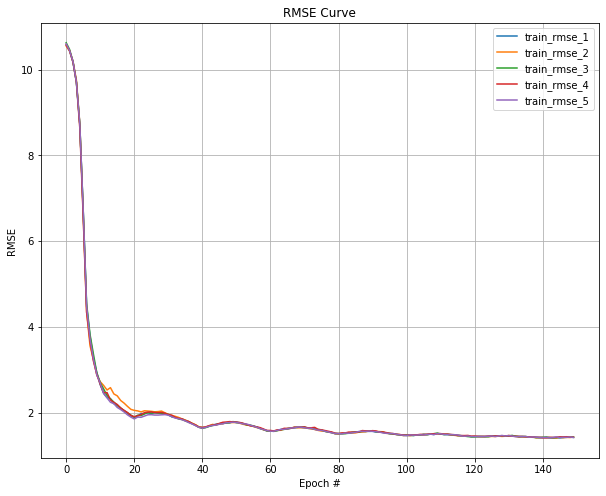

In [0]:
plt.figure(figsize=(10,8))
plt.plot(rmse_values["train_rmse_1"], label='train_rmse_1')
plt.plot(rmse_values["train_rmse_2"], label='train_rmse_2')
plt.plot(rmse_values["train_rmse_3"], label='train_rmse_3')
plt.plot(rmse_values["train_rmse_4"], label='train_rmse_4')
plt.plot(rmse_values["train_rmse_5"], label='train_rmse_5')
plt.ylabel('RMSE')
plt.xlabel('Epoch #')
plt.title("RMSE Curve")
plt.legend()
plt.grid()
plt.show()

In [0]:
plt.plot(clr.history["lr"])
plt.ylabel('Learning Rate')
plt.xlabel('Iteration #')
plt.title("Cyclical Learning Rate (CLR)")
plt.grid()
plt.show()

## Create submission File

In [0]:
Ypredict = np.exp(Ypredict).astype(int)
predict_df = pd.DataFrame(Ypredict, index=None, columns=['Views'])

In [0]:
# Read submission file
submit_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Chartbusters Prediction - Foretell The Popularity Of Songs/Datasets/Sample_Submission.csv")

In [0]:
# Create final submission data
submit_df['Views'] = predict_df['Views']

# Write submission data into a CSV file
submit_df.to_excel("MySubmission.xlsx", index=False)

## Save the model (for reusability)

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/Chartbusters Prediction - Foretell The Popularity Of Songs/Chartbusters_Songs_Popularity_Prediction_Model.h5')